# Monitoring and Predicting Elasticity in Kubernetes

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import json
import scipy.signal as ss
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

# Introduction

## Goal of this project

This project has two main goals:

### 1. Monitoring Kubernetes:
Investigating ways to monitor Kubernetes in order to get information about the configuration of the deployed Software system at runtime. In particular, we are interested how many pods of each service are running and to which compute nodes they are scheduled. 

### 2. Predicting reconfigurations:
Learning behavioral patterns of Kubernetes in order to be able to predict reconfigurations, such as elastic rescaling, i.e. addition or removal of pods of specific services.

## Background
The main motivation for this work, is to provide information about the current configuration of the deployed system to an online model checker that verifies the correctness of every new system configuration. 
In a second step, the prediciton could be used to precompute model checking results at times where the model checker would otherwise be idle.

## Setup
All parts of the project were tested on a local Kubernetes cluster run on [Minikube](https://kubernetes.io/docs/tasks/tools/install-minikube/). As currently the support for running multi node clusters locally is very limited, all experiments were run in a setup with only one compute node. The virtual machine running the compute node had access to the following resources:

* 6 cores
* 6 GB RAM
* 32 GB disk storage

Testing similar solutions on clusters with multiple nodes and more compute power would be an interesting future extension.

### Example application
As example application that is deployed on Kubernetes I used a Google demo application which implements an online shop where users can browse items, add them to the cart, and purchase them. Code, build and deployment instructions can be found [here](https://github.com/GoogleCloudPlatform/microservices-demo).
The application consists of 10 different microservices. The following two microserveices are of importance for the experiments run in this project:

##### Frontend
Exposes an HTTP server to serve the website. 

##### Loadgenerator
Continuously sends requests imitating realistic user shopping flows to the frontend. Each pod running the loadgenerator service simulates the behavior of 10 users, which continuously browse items, add them to the cart, and perform purchases.

## Elastic rescaling
Changes in the input load, can be simulated by rescaling the number of loadgenerator pods. For example, the arrival of 10 new users is modelled by adding one loadgenerator pod.

In order to experiment with elastic rescaling, the number of frontend pods was dynamically controlled using a Kubernetes [horizontal pod autoscaler](https://kubernetes.io/docs/tasks/run-application/horizontal-pod-autoscale/) which automatically adds or removes pods based on observed CPU utilization. The autoscaler was configuread to schedule between 1 and 10 frontend pods and to add more pods whenever the observed CPU usage of the existing pods is more than 30%. This relatively low threshold was chosen in order to be able to observe more rescaling events in the generated outputs.




# Key findings





# 1. Monitoring Kubernetes


### Monitoring -  kubectl get events for the kind of info we want
* alternatives: Prometheus e.a.
* extract as json
* event types + fields - show examples
* also descibe other events (scheduling....)
* deleted every hour!

Code to include and briefly explain:
* loadcontroler
* event scraper

### Generating traces

In [1]:
def eventsToTrace(filnames):
    trace_dict = {}

    for file in filenames:
        with open(file) as events_file:
            events = json.load(events_file)
            for e in events['items']:
                if(e['reason']=='Created' or e['reason']=='Killing'):
                    time = datetime.datetime.strptime(e['firstTimestamp'], "%Y-%m-%dT%H:%M:%SZ")
                    trace_dict[e['metadata']['uid']] = [time, e['metadata']['name'], e['metadata']['name'].partition('-')[0], e['reason']]


    trace = pd.DataFrame.from_dict(trace_dict, orient='index')
    trace.columns = ['time', 'name', 'podType', 'event']
    trace.sort_values(by=['time'], inplace=True)

    return trace

In [2]:
def traceToTimeseries(trace_p):
    matrix = pd.DataFrame(columns = ['time', 'nrLoadgenerators', 'nrFrontends'])
    stepSize = datetime.timedelta(seconds=60)
    # sort trace by time
    trace_p.sort_values(by=['time'], inplace=True)
    # assumption: starting from 1,1 config
    # first row: all 1, then increment gradually 
    firstTs = trace_p['time'].iloc[0]
    lastTs = trace_p['time'].iloc[-1]
    
    currentTime = firstTs - stepSize
    #print('start:')
    #print(currentTime)
    nrFrontends = 1
    nrLoadgenerators = 1
    matrix = matrix.append(pd.Series([currentTime, nrLoadgenerators, nrFrontends], index=matrix.columns), ignore_index=True)
    idx = 0


    # walk over trace + evaluate change at every step
    while(currentTime <= lastTs + stepSize):
        while(idx < len(trace_p) and trace_p['time'].iloc[idx] <= currentTime):
            if(trace_p['podType'].iloc[idx] == 'frontend' and trace_p['event'].iloc[idx] == 'Killing'):
                nrFrontends = nrFrontends - 1
            if(trace_p['podType'].iloc[idx] == 'frontend' and trace_p['event'].iloc[idx] == 'Created'):
                nrFrontends = nrFrontends + 1
            if(trace_p['podType'].iloc[idx] == 'loadgenerator' and trace_p['event'].iloc[idx] == 'Killing'):
                nrLoadgenerators = nrLoadgenerators - 1
            if(trace_p['podType'].iloc[idx] == 'loadgenerator' and trace_p['event'].iloc[idx] == 'Created'):
                nrLoadgenerators = nrLoadgenerators + 1
            idx = idx + 1
        
        currentTime = currentTime + stepSize
        matrix = matrix.append(pd.Series([currentTime, nrLoadgenerators, nrFrontends], index=matrix.columns), ignore_index=True)

    return matrix


# 2. Predicting reconfigurations:

The goal of this part of the project is to build a machine learning model for predicting Kubernetes reconfigurations.
Given the somehow limited experimental setup (single node, restricted compute resources), I decided to focus on the following question: 

**Given the temporal history of the load and the number of frontends, can we predict how many frontend pods will be running at the next point in time?**

The first challenge was to construct an appropriate training data set. I created such a data set by monitoring the behavior of the Minikube cluster running the online shop application when confronted with typical load.

## Modelling the load

In order to be able to model realistic input load, I was looking for a way to estimate how many users typically visit online shops over the course of time. To this means, I used an external data set that contains Google Analytics data from the Google Merchandise Store, an ecommerce store selling Google branded merchandise. 
A detailed description of the data set and instructions how to retrieve the data can be found [here](https://www.kaggle.com/bigquery/google-analytics-sample).

I extracted a table from the data set with an entry for every newly started user session in the month of July 2017.

In [4]:
data = pd.read_csv("data.csv", index_col=0) 
data['visitStartTime'] = pd.to_datetime(data['visitStartTime'],unit='s')
data['date'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).date())
data['hour'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).replace(minute=0, second=0))

data.head()

,visitStartTime,continent,country,date,hour
0,2017-07-01 07:00:05,Americas,United States,2017-07-01,2017-07-01 07:00:00
1,2017-07-01 07:01:53,Asia,Philippines,2017-07-01,2017-07-01 07:00:00
2,2017-07-01 07:02:25,Americas,United States,2017-07-01,2017-07-01 07:00:00
3,2017-07-01 07:02:29,Americas,United States,2017-07-01,2017-07-01 07:00:00
4,2017-07-01 07:02:31,Asia,Philippines,2017-07-01,2017-07-01 07:00:00


In [5]:
data.shape

(71812, 5)

In order to use this data for the simulation, I computed the number of user sessions per hour. While for our applicaiton, it might make more sense to simulate how many users arrive every second or minute, the user numbers in the data sets where comparably low. Hence counting the users per hour yielded a more interesting pattern of user numbers.


In [14]:
ts = data.groupby(['hour', 'date']).count()['visitStartTime']

In [ ]:
The plot sh

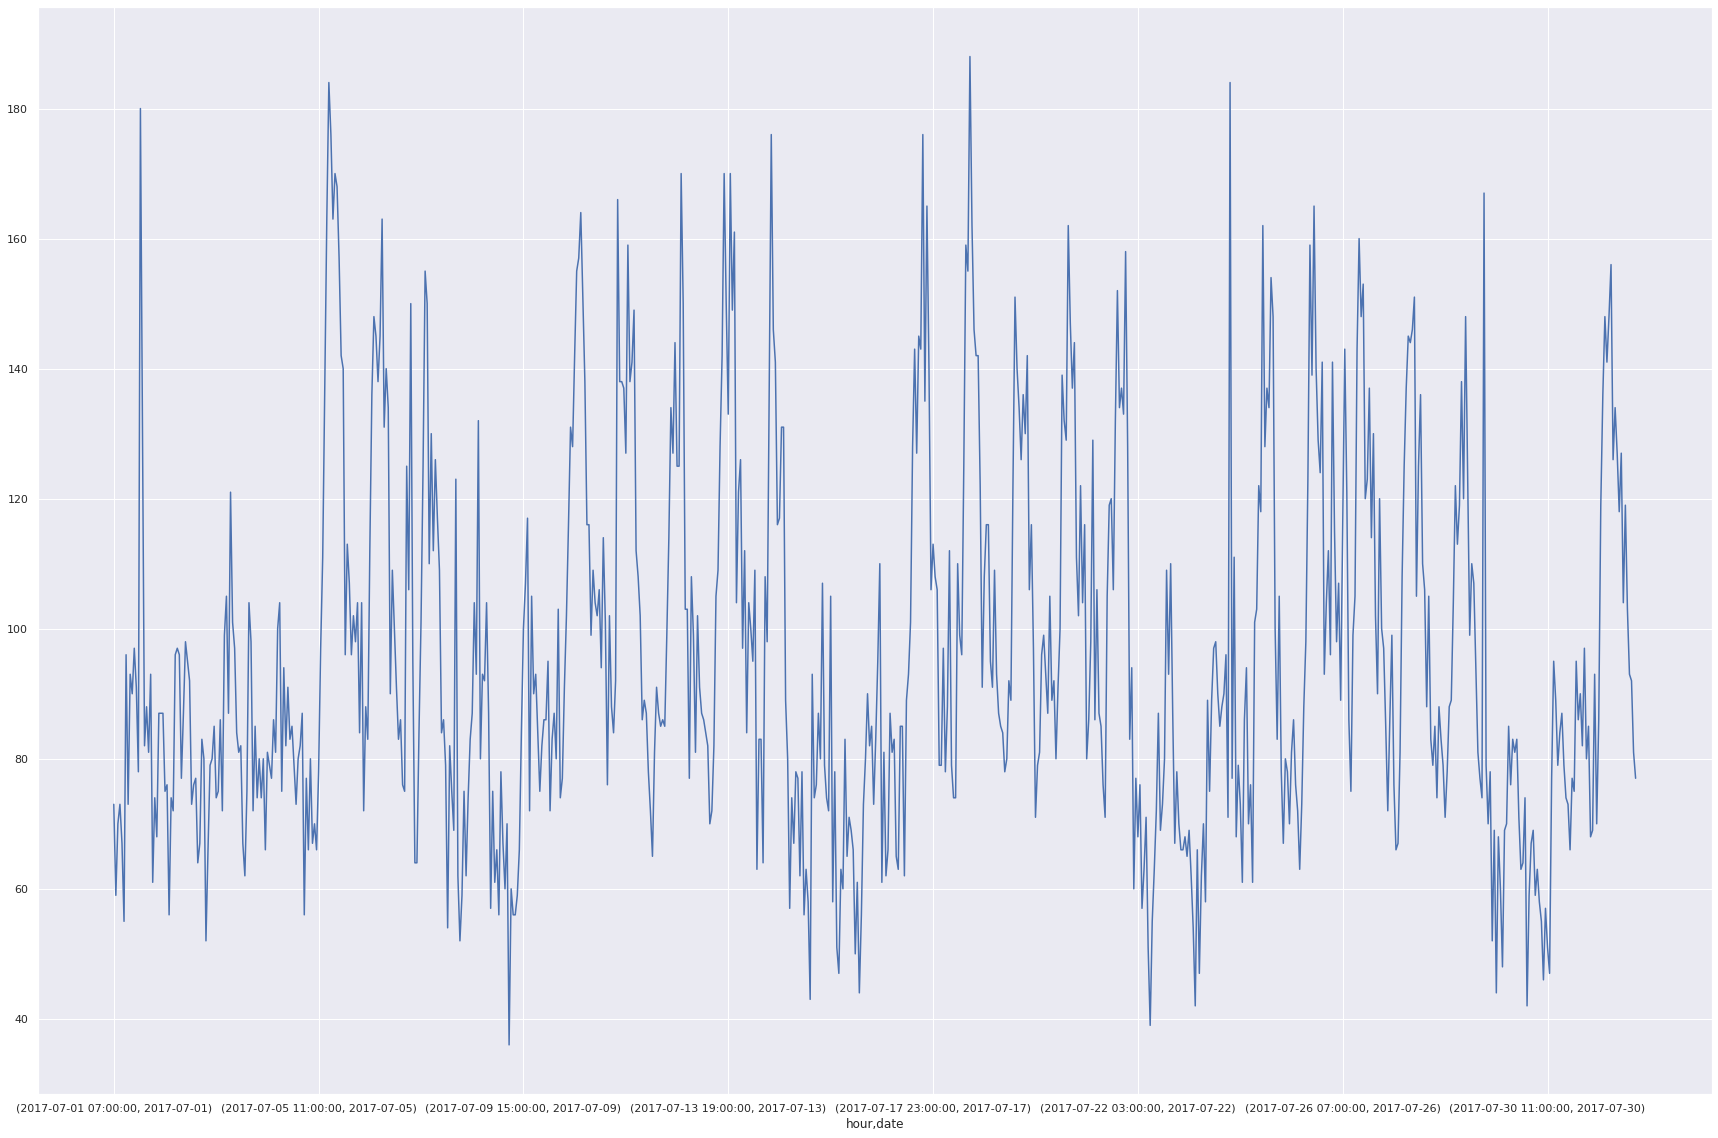

In [12]:
ts.plot(figsize=(30,20))
plt.show()

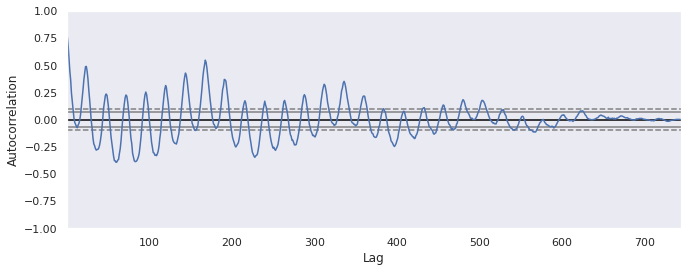

In [16]:
pd.plotting.autocorrelation_plot(ts)
plt.show()

In [ ]:
ts_scaled = ts//20
ts_scaled.head()

In [ ]:
ts_scaled.describe()

In [ ]:
ts_scaled.plot(figsize=(10,10))
plt.show()

In [ ]:
#ts_scaled.to_csv('load.csv', index=False)

## Running the simulation

## Prepare simulation results

### Generate trace

In [ ]:
filenames = []

for i in range(1, 31):
    filenames.append('data/eventspart' + str(i) + '.txt')

trace = eventsToTrace(filenames)

#truncate parts before and after simulation
trace = trace[trace['time'] > datetime.datetime(2020, 9, 26, 14, 15)]
trace = trace[trace['time'] < datetime.datetime(2020, 9, 27, 3, 0)]

trace.head()

In [ ]:
#filenames = []

#for i in range(1, 38):
#    filenames.append('data/real/realeventspart' + str(i) + '.txt')

#trace = eventsToTrace(filenames)

#truncate parts before and after simulation
#trace = trace[trace['time'] > datetime.datetime(2020, 9, 28, 1, 24)]

#trace.tail(14)

In [ ]:
trace.shape

### Generate Time Series

In [ ]:
matrix = traceToTimeseries(trace)
matrix = matrix.set_index('time')
matrix['nrFrontends'] = matrix['nrFrontends'].astype(int)
matrix['nrLoadgenerators'] = matrix['nrLoadgenerators'].astype(int)
matrix.head()

In [ ]:
matrix.dtypes

In [ ]:
matrix.shape

In [ ]:
matrix.plot(y=['nrLoadgenerators', 'nrFrontends'], figsize=(10,5), grid=True)
plt.show()

In [ ]:
matrix.describe()

In [ ]:
matrix.boxplot(column='nrLoadgenerators',by='nrFrontends')
plt.show()

In [ ]:
# simple correlation
matrix["nrFrontends"].corr(matrix["nrLoadgenerators"], method='spearman')


In [ ]:
# ccf
def ccf(x, y, lag_max = 100):

    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]


c = ccf(matrix['nrFrontends'], matrix['nrLoadgenerators'])
print('maximal correlation: ', np.max(c))
print('lag: ', np.argmax(c) - 100)
plt.plot(c)
plt.show()

#### Feature engineering

TODO: describe

In [ ]:
def computeFeatures(matrix):
    
    # add load and frontend numbers at times i-1,..., i-5
    lagged = []
    for i in range(1, 6):
        matrix_1 = matrix.shift(periods=i)
        matrix_1.columns = ['nrFrontends_' + str(i), 'nrLoadgenerators_' + str(i)]
        lagged.append(matrix_1)
    lagged.insert(0, matrix)
    features = pd.concat(lagged, axis=1)
    
    features.fillna(0, inplace=True)

    # add change in last step
    features['frontendChange'] = features['nrFrontends'] - features['nrFrontends_1']
    features['loadChange'] = features['nrLoadgenerators'] - features['nrLoadgenerators_1']
    
    #add time since last change in minutes
    features['decF'] = features['nrFrontends'] < features['nrFrontends_1']
    features['incF'] = features['nrFrontends'] > features['nrFrontends_1']
    features['decL'] = features['nrLoadgenerators'] < features['nrLoadgenerators_1']
    features['incL'] = features['nrLoadgenerators'] > features['nrLoadgenerators_1']

    features['lastIncF'] = datetime.timedelta(0)
    features['lastDecF'] = datetime.timedelta(0)
    features['lastIncL'] = datetime.timedelta(0)
    features['lastDecL'] = datetime.timedelta(0)

    lastIncF = features.index[0]
    lastDecF = features.index[0]
    lastIncL = features.index[0]
    lastDecL = features.index[0]
    for index, row in features.iterrows():
        if(row['incF']):
            lastIncF = index
        if(row['decF']):
            lastDecF = index
        if(row['incL']):
            lastIncL = index
        if(row['decL']):
            lastIncL = index
        features.at[index, 'lastIncF'] = index - lastIncF
        features.at[index, 'lastIncL'] = index - lastIncL
        features.at[index, 'lastDecF'] = index - lastDecF
        features.at[index, 'lastDecL'] = index - lastDecL
    
    # transform timedelta to number of minutes
    features['lastIncF'] = features['lastIncF'].apply(lambda x: x.total_seconds()//60)
    features['lastDecF'] = features['lastDecF'].apply(lambda x: x.total_seconds()//60)
    features['lastIncL'] = features['lastIncL'].apply(lambda x: x.total_seconds()//60)
    features['lastDecL'] = features['lastDecL'].apply(lambda x: x.total_seconds()//60)
    
    return features

In [ ]:
features = computeFeatures(matrix)
features.head()

In [ ]:
features.dtypes

In [ ]:
features.corr(method='spearman')

## Models

### 1. Random forest
* columns not lin indep (-> no GLM)
* frontends depend on load 
* load could be modelled using time series model 

#### a) Regression


In [ ]:
labels = np.array(features['nrFrontends'])
features_ml = features.drop('nrFrontends', axis = 1)

feature_list = list(features_ml.columns)
features_ml = np.array(features_ml)

In [ ]:
#random split 80 20
train_features, test_features, train_labels, test_labels = train_test_split(features_ml, labels, test_size = 0.2, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
predictions = rf.predict(test_features)

errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), '....')

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
pred_rounded = np.rint(predictions).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(test_labels, pred_rounded, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))


In [ ]:
balanced_accuracy_score(test_labels, pred_rounded)

In [ ]:
results = pd.DataFrame({'actual': test_labels, 'predicted': pred_rounded})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

In [ ]:
#features['pred'] = rf.predict(features_ml)
#features.plot(y=['pred', 'nrFrontends'], figsize=(10,5), grid=True)
#plt.show()

In [ ]:
l = list(zip(features.drop('nrFrontends', axis = 1).columns, rf.feature_importances_))

sorted(l, key = lambda x: x[1], reverse=True) 


In [ ]:
# Train and evaluate with reduced number of features
features_filtered = features[['nrLoadgenerators_1', 'nrFrontends_2', 'nrFrontends_1', 'lastDecL', 'nrFrontends_4', 'frontendChange']]

feature_list_red = list(features_filtered.columns)
features_filtered = np.array(features_filtered)

#random split 80 20
train_features_red, test_features_red, train_labels_red, test_labels_red = train_test_split(features_filtered, labels, test_size = 0.2, random_state = 42)

rf_red = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf_red.fit(train_features_red, train_labels_red);

In [ ]:
predictions_red = rf_red.predict(test_features_red)

pred_rounded_red = np.rint(predictions_red).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(test_labels, pred_rounded_red, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))

balanced_accuracy_score(test_labels, pred_rounded_red)



In [ ]:
results = pd.DataFrame({'actual': test_labels, 'predicted': pred_rounded_red})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

#### b) Multiclass classification

In [ ]:
factor = pd.factorize(features['nrFrontends'])
labels_cat = factor[0]
definitions = factor[1]

# train test split
X_train, X_test, y_train, y_test = train_test_split(features_ml, labels_cat, test_size = 0.2, random_state = 42)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
#Reverse factorizetpandas 
reversefactor = dict(zip(range(6),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))


In [ ]:
balanced_accuracy_score(y_test, y_pred)

In [ ]:
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

### Cross validation - split on weeks

In [ ]:
features.index.apply(lambda x: x.isocalendar()[1])




In [ ]:
labels = np.array(features['nrFrontends'])
features_ml = features.drop('nrFrontends', axis = 1)

feature_list = list(features_ml.columns)
features_ml = np.array(features_ml)

# Test on Random data

In [ ]:
#generate trace
filenames = []

for i in range(1, 8):
    filenames.append('data/randomeventspart' + str(i) + '.txt')

trace_random = eventsToTrace(filenames)

#truncate parts before and after simulation
trace_random = trace_random[trace_random['time'] > datetime.datetime(2020, 9, 27, 22, 15)]
trace_random = trace_random[trace_random['time'] < datetime.datetime(2020, 9, 28, 0, 22)]

trace_random.head()

In [ ]:
matrix_rand = traceToTimeseries(trace_random)
matrix_rand = matrix_rand.set_index('time')
matrix_rand['nrFrontends'] = matrix_rand['nrFrontends'].astype(int)
matrix_rand['nrLoadgenerators'] = matrix_rand['nrLoadgenerators'].astype(int)
matrix_rand.head()

In [ ]:
matrix_rand['nrLoadgenerators'].plot()
plt.show()

In [ ]:
matrix_rand.groupby('nrLoadgenerators').count()

In [ ]:
features_rand = computeFeatures(matrix_rand)
labels_rand = np.array(features_rand['nrFrontends'])
features_ml_rand = features_rand.drop('nrFrontends', axis = 1)

features_ml_rand = np.array(features_ml_rand)


In [ ]:
predictions_rand = rf.predict(features_ml_rand)

errors = abs(predictions_rand - labels_rand)
print('Mean Absolute Error:', round(np.mean(errors), 2), '....')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / labels_rand)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
pred_rounded_rand = np.rint(predictions_rand).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(labels_rand, pred_rounded_rand, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))


In [ ]:
balanced_accuracy_score(labels_rand, pred_rounded_rand)

In [ ]:
features_rand['pred'] = pred_rounded_rand
features_rand.plot(y=['pred', 'nrFrontends'], figsize=(10,5), grid=True)
plt.show()

In [ ]:

mse = mean_squared_error(features_rand['nrFrontends'], features_rand['pred'])


rmse = math.sqrt(mse)


print(rmse)

#### reduced features

In [ ]:
features_rand_red = features_rand[['nrLoadgenerators_1', 'nrFrontends_2', 'nrFrontends_1', 'lastDecL', 'nrFrontends_4', 'frontendChange']]

features_rand_red = np.array(features_rand_red)

predictions_rand_red = rf_red.predict(features_rand_red)

pred_rounded_rand_red = np.rint(predictions_rand_red).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(labels_rand, pred_rounded_rand_red, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))

balanced_accuracy_score(labels_rand, pred_rounded_rand_red)

In [ ]:
results = pd.DataFrame({'actual': labels_rand, 'predicted': pred_rounded_rand_red})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

In [ ]:
# Test Regression
factor_rand = pd.factorize(features_rand['nrFrontends'])
labels_cat_rand = factor_rand[0]
definitions_rand = factor_rand[1]




In [ ]:
# Predicting the Test set results
y_pred_rand = classifier.predict(features_ml_rand)
reversefactor = dict(zip(range(7),definitions_rand))
y_rand = np.vectorize(reversefactor.get)(labels_cat_rand)
y_pred_rand = np.vectorize(reversefactor.get)(y_pred_rand)

# Making the Confusion Matrix
print(pd.crosstab(y_rand, y_pred_rand, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))

In [ ]:
balanced_accuracy_score(y_rand, y_pred_rand)

In [ ]:
results = pd.DataFrame({'actual': y_rand, 'predicted': y_pred_rand})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

# Minute data

**TODO**
1 leave 1 out CV (je 1 Woche raus)
2 random confusion matrix neu berechnen
3 feature grtance - sort by importance + alles weglassen was in 2. nk stelle 0 hat
4 beschreibungen und interpretation schreiben
5 verteilung der random daten
6 bestehendes Model verbessern: filter drüber legen, hidden markov, vl doch noch was zeitreihenspezifisches
7 neue daten für min=min aufbereiten und damit neuen classifier trainieren
8 proof of concept: limitations - more nodes + power for more load needed - RF is sensible to unbalanced groups



* for interpretation: not dependentant on current load but on recent load --> kubernetes takes some time to react - or it takes time for users to become active?
* write
* mention 1h = 1 min

RF:
Zeitlivhe abhängigkeit egal -> robust gegen changes of season & trend
Lineare abhängigkeit der inputvektoren egal
Verwendung von kovariablen möglich
Via load forecasting predicted load mögliches inputfeature, dann n-step ahead prediction möglich



In [ ]:
filenames = []

for i in range(1, 38):
    filenames.append('data/real/realeventspart' + str(i) + '.txt')

trace = eventsToTrace(filenames)

#truncate parts before and after simulation
#trace = trace[trace['time'] > datetime.datetime(2020, 9, 26, 14, 15)]
#trace = trace[trace['time'] < datetime.datetime(2020, 9, 27, 3, 0)]

trace.head()